In [1]:
data_path = '/kaggle/input/brazilian-sign-language/'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
face_fragments = {
    'left_eye': list(range(0, 8)),
    'right_eye': list(range(8, 16)),
    'left_eyebrow': list(range(16, 26)),
    'right_eyebrow': list(range(26, 36)),
    'nose': list(range(36, 48)),
    'mouth': list(range(48, 68)),
    'face_contour': list(range(68, 87)),
    'irises_and_nose_tip': list(range(87, 90)),
    'line_above_left_eyebrow': list(range(90, 95)),
    'line_above_right_eyebrow': list(range(95, 100))
}

In [4]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"using {device}...")

using cuda...


In [324]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [325]:
oh_enc = OneHotEncoder(sparse_output=False)
scaler = StandardScaler()

In [326]:
class ExpressionDataset(Dataset):
  def __init__(self, csv_file, scaler, oh_encoder, train=True):
    super().__init__()
    self.train = train
    df = pd.read_csv(csv_file, index_col=0, keep_default_na=False)
    self.data = df.drop(columns=['label'])
    self.labels = df['label']
    self.normalize(scaler)
    self.one_hot_encode(oh_encoder)

  def normalize(self, scaler):
    if self.train:
      scaler.fit(self.data)
    self.data = scaler.transform(self.data)

  def one_hot_encode(self, oh_encoder):
    if self.train:
      oh_encoder.fit(self.labels.to_numpy().reshape(-1, 1))
    self.labels = oh_encoder.transform(self.labels.to_numpy().reshape(-1, 1))

  def balance_dataset(self, smote):
    smote.fit_resample(self.data, self.labels)

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    input = self.data[idx]
    label = self.labels[idx]
    return input, label

In [327]:
training_set = ExpressionDataset(f"{data_path}training_set.csv", scaler=scaler, oh_encoder=oh_enc, train=True)
valid_set = ExpressionDataset(f"{data_path}validation_set.csv", scaler=scaler, oh_encoder=oh_enc, train=False)
test_set = ExpressionDataset(f"{data_path}test_set.csv", scaler=scaler, oh_encoder=oh_enc, train=False)

train_dataloader = DataLoader(training_set, batch_size=512, shuffle=False)
valid_dataloader = DataLoader(valid_set, batch_size=256, shuffle=False)
test_dataloader = DataLoader(test_set, batch_size=256, shuffle=False)

# **Model**

In [367]:
class FaceFragment(torch.nn.Module):
    def __init__(self, n_points, dropout=0.2):
        super().__init__()
        self.n_points = n_points
        self.linear1 = torch.nn.Linear(n_points, n_points * 32)
        self.lrelu1 = torch.nn.LeakyReLU()
        self.norm = torch.nn.LayerNorm(n_points * 32)
        self.dropout = torch.nn.Dropout(p=dropout)
        self.linear2 = torch.nn.Linear(n_points * 32, 256)
        self.lrelu2 = torch.nn.LeakyReLU()

    def forward(self, x):
        x = self.lrelu1(self.linear1(x))
        x = self.dropout(self.norm(x))
        return self.lrelu2(self.linear2(x))

In [368]:
class Model(torch.nn.Module):
  def __init__(self, dropout=0.2):
    super().__init__()
    self.W = torch.nn.Parameter(torch.empty(100, 3), requires_grad=True)
    torch.nn.init.kaiming_uniform_(self.W)

    self.faceFragmentModules = torch.nn.ModuleList(FaceFragment(len(points), dropout=dropout) for points in face_fragments.values())

    self.lrelu1 = torch.nn.LeakyReLU()
    self.norm1 = torch.nn.LayerNorm(256 * len(face_fragments))
    self.dropout1 = torch.nn.Dropout(p=dropout)
    self.linear1 = torch.nn.Linear(256 * len(face_fragments), 64 * len(face_fragments))
    self.lrelu2 = torch.nn.LeakyReLU()
    self.norm2 = torch.nn.LayerNorm(64 * len(face_fragments))
    self.dropout2 = torch.nn.Dropout(p=dropout)
    self.linear2 = torch.nn.Linear(64 * len(face_fragments), 10)

    self.double()

  def forward(self, x):
    x = x.reshape(-1, 100, 3)
    x = torch.sum(x * self.W, dim=-1)
    outputs = [self.faceFragmentModules[i](x[:, points[0]:points[-1]+1]) for i, points in enumerate(face_fragments.values())]
    x = torch.cat(outputs, dim=-1)
    x = self.dropout1(self.norm1(x))
    x = self.lrelu2(self.linear1(x))
    x = self.dropout2(self.norm2(x))
    return torch.nn.functional.softmax(self.linear2(x), dim=-1)


In [370]:
def train(model, optimizer, loss_f, loader, device=torch.device('cpu')):
  model.train()
  correct = 0
  total = 0
  loss_total = 0.0
  for batch, (inputs, labels) in enumerate(loader):
    optimizer.zero_grad()
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    loss = loss_f(outputs, labels)
    loss.backward()
    optimizer.step()
    loss_total += loss.item()
    correct += torch.sum(torch.argmax(outputs, dim=-1) == torch.argmax(labels, dim=-1))
    total += len(labels)
    # print(f"batch {batch}/{len(loader)}, batch_loss: {loss}")
  accuracy = correct / total
  return accuracy, loss_total / len(loader)

In [371]:
def valid(model, loss_f, loader, device=torch.device('cpu')):
  model.eval()
  correct = 0
  total = 0
  loss_total = 0.0
  with torch.no_grad():
    for inputs, labels in loader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      loss = loss_f(outputs, labels)
      loss_total += loss.item()
      correct += torch.sum(torch.argmax(outputs, dim=-1) == torch.argmax(labels, dim=-1))
      total += len(labels)

  accuracy = correct / total
  return accuracy, loss_total / len(loader)

In [372]:
model = Model(dropout=0.1).to(device)
loss_f = torch.nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=8, factor=0.2)

print(f"parameter count: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

parameter count: 2524854


In [373]:
num_epochs = 400
last_lr = lr
for epoch in range(num_epochs):
    train_acc, train_loss = train(model, optimizer, loss_f, train_dataloader, device=device)
    print(f"epoch {epoch}, training_loss: {train_loss:.4f}, training_accuracy: {train_acc:.4f}")
    valid_acc, valid_loss = valid(model, loss_f, valid_dataloader, device=device)
    print(f"epoch {epoch}, validation_loss: {valid_loss:.4f}, validation_accuracy: {valid_acc:.4f}")
    scheduler.step(valid_loss)
    if last_lr > scheduler.get_last_lr()[0]:
      last_lr = scheduler.get_last_lr()[0]
      if last_lr < 1e-7:
        print(f"Early stopping activated...")
        break
      else:
        print(f"Learning rate decreased. New learning rate: {last_lr:.8f}")
    print(f"------------------------------------------------------------------")
print(f"Model training ended")

epoch 0, training_loss: 1.8070, training_accuracy: 0.6553
epoch 0, validation_loss: 1.7898, validation_accuracy: 0.6711
------------------------------------------------------------------
epoch 1, training_loss: 1.7807, training_accuracy: 0.6807
epoch 1, validation_loss: 1.7741, validation_accuracy: 0.6865
------------------------------------------------------------------
epoch 2, training_loss: 1.7682, training_accuracy: 0.6931
epoch 2, validation_loss: 1.7713, validation_accuracy: 0.6893
------------------------------------------------------------------
epoch 3, training_loss: 1.7676, training_accuracy: 0.6933
epoch 3, validation_loss: 1.7734, validation_accuracy: 0.6872
------------------------------------------------------------------
epoch 4, training_loss: 1.7601, training_accuracy: 0.7016
epoch 4, validation_loss: 1.7610, validation_accuracy: 0.7001
------------------------------------------------------------------
epoch 5, training_loss: 1.7519, training_accuracy: 0.7096
epoch 5

# **Validation**
#### Used to tune model's hyperparameters

In [374]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from matplotlib.colors import LogNorm

import warnings
warnings.filterwarnings("ignore")

In [375]:
def evaluate(model, loader, device=torch.device('cpu')):
  predictions = []
  correct_labels = []
  with torch.no_grad():
    for inputs, labels in loader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      prediction = torch.argmax(outputs, dim=-1)
      correct_label = torch.argmax(labels, dim=-1)
      predictions.append(prediction)
      correct_labels.append(correct_label)

  predictions = torch.cat(predictions).to(torch.device('cpu'))
  correct_labels = torch.cat(correct_labels).to(torch.device('cpu'))
  conf_matrix = confusion_matrix(correct_labels, predictions)
  accuracy = accuracy_score(correct_labels, predictions)
  report = classification_report(correct_labels, predictions, target_names=oh_enc.categories_[0])

  return conf_matrix, report, accuracy

def plot_evaluation(conf_matrix, labels):
  

  ax = sns.heatmap(conf_matrix, annot=True, fmt='d', norm=LogNorm())
  ax.set(xlabel='Predicted', ylabel='Actual')
  ax.xaxis.set_ticklabels(labels, rotation=90, wrap=True, fontsize=10, va='center', ha='right')
  ax.yaxis.set_ticklabels(labels, rotation=0, wrap=True, fontsize=10)
  ax.set_title('Confusion matrix', fontsize=18)

  plt.show()

accuracy: 0.9366
                precision    recall  f1-score   support

          None       0.95      0.96      0.96      1807
   affirmative       0.89      0.88      0.89        97
   conditional       0.92      0.88      0.90       123
doubt_question       0.97      0.91      0.94       122
      emphasis       0.93      0.93      0.93        85
      negative       0.88      0.87      0.87       115
      relative       0.95      0.91      0.93       120
        topics       0.89      0.80      0.84        88
   wh_question       0.84      0.93      0.88       109
   yn_question       0.93      0.91      0.92       128

      accuracy                           0.94      2794
     macro avg       0.91      0.90      0.90      2794
  weighted avg       0.94      0.94      0.94      2794



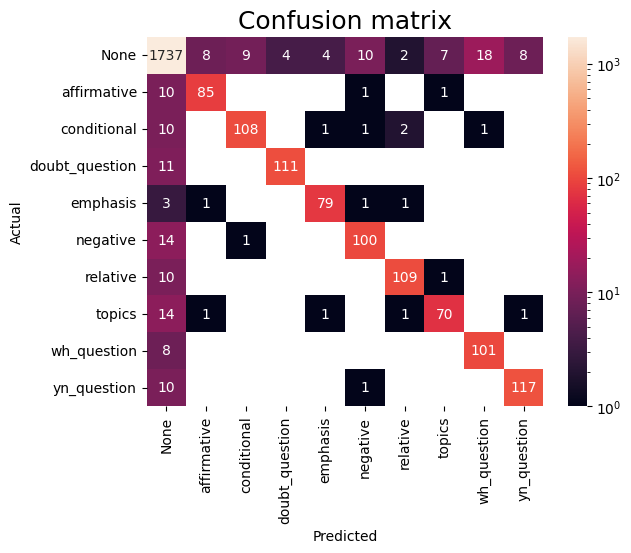

In [376]:
conf_matrix, report, accuracy = evaluate(model, valid_dataloader, device)
print(f"accuracy: {accuracy:.4f}")
print(report)
plot_evaluation(conf_matrix, oh_enc.categories_[0])

# **Test**
#### Final evaluation of model's performance

accuracy: 0.9302
                precision    recall  f1-score   support

          None       0.94      0.96      0.95      1765
   affirmative       0.95      0.81      0.87        85
   conditional       0.98      0.89      0.93       132
doubt_question       0.90      0.93      0.91       120
      emphasis       0.92      0.86      0.89        94
      negative       0.91      0.89      0.90       142
      relative       0.90      0.85      0.88       122
        topics       0.87      0.84      0.86        88
   wh_question       0.91      0.88      0.89       114
   yn_question       0.91      0.89      0.90       132

      accuracy                           0.93      2794
     macro avg       0.92      0.88      0.90      2794
  weighted avg       0.93      0.93      0.93      2794



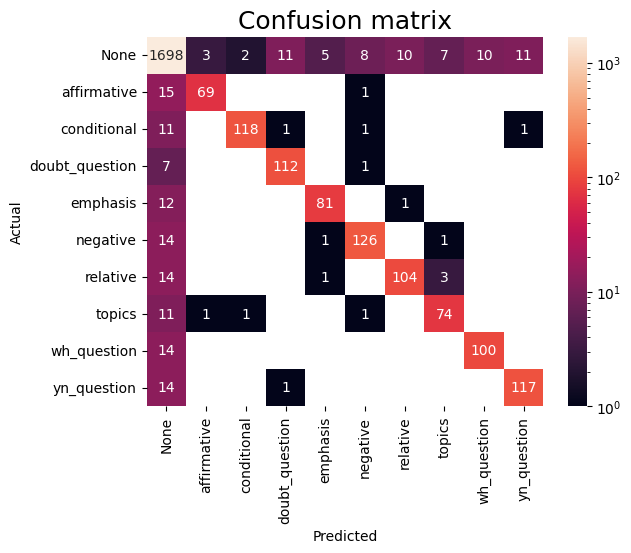

In [377]:
conf_matrix, report, accuracy = evaluate(model, test_dataloader, device)
print(f"accuracy: {accuracy:.4f}")
print(report)
plot_evaluation(conf_matrix, oh_enc.categories_[0])